In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
data = pd.read_excel('processed.xlsx')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


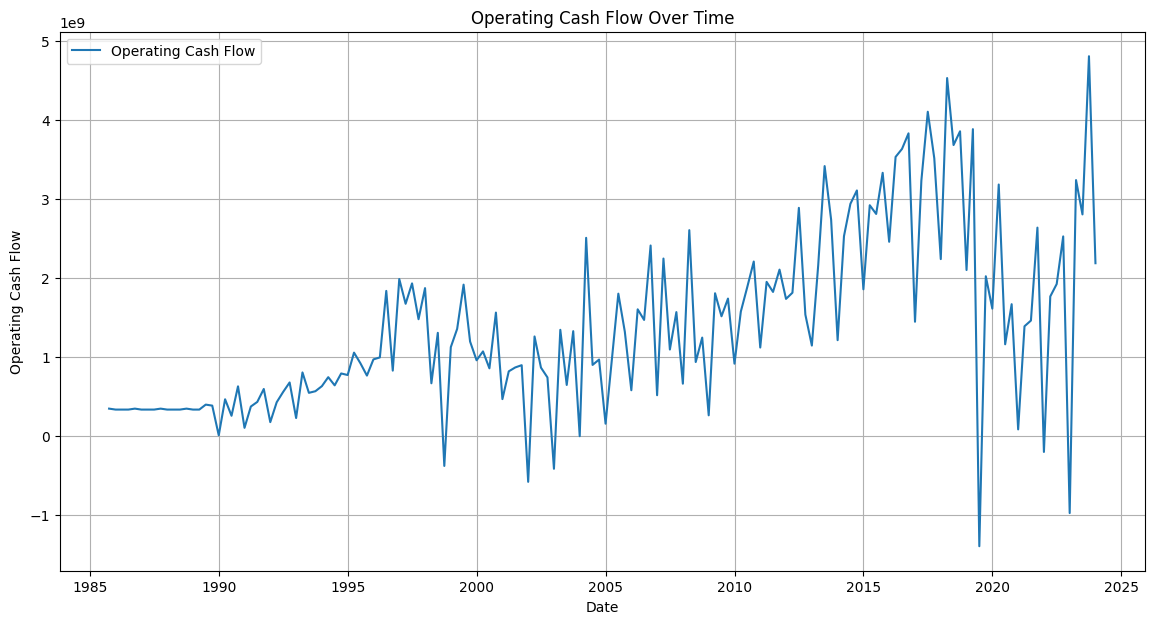

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

operating_cash_flow_col = 'OperatingCashFlow'
# Plot Operating Cash Flow
plt.figure(figsize=(14, 7))
plt.plot(data.index, data[operating_cash_flow_col], label='Operating Cash Flow')
plt.title('Operating Cash Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

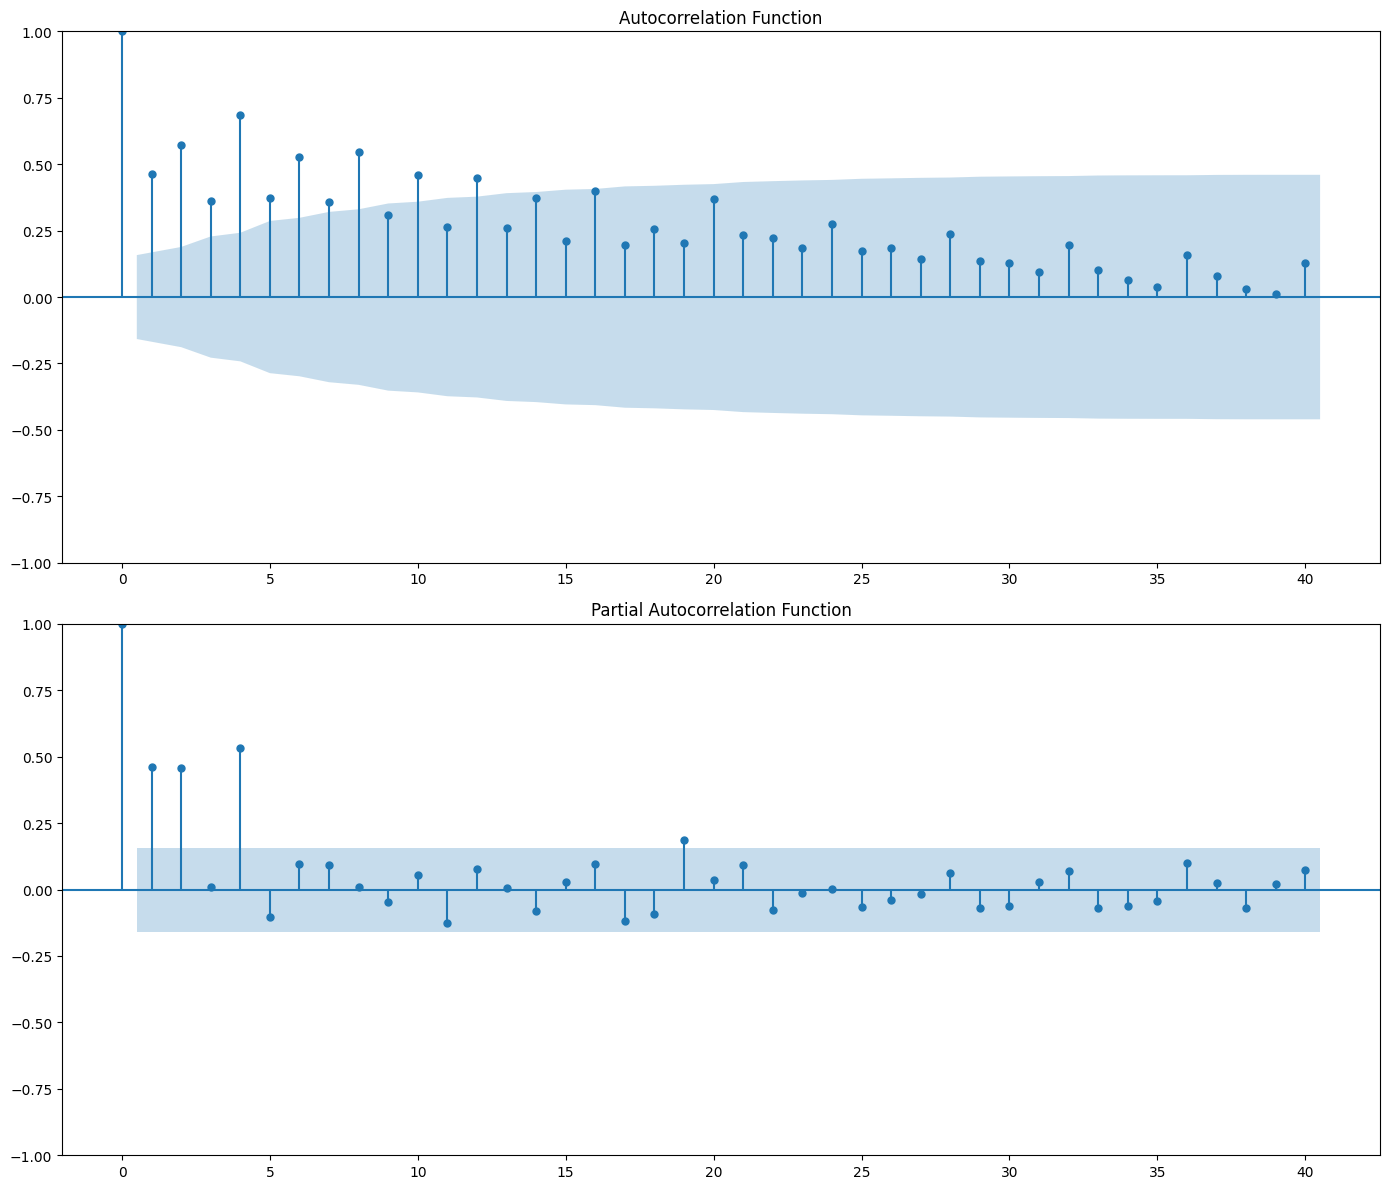

In [4]:
# Generate ACF and PACF plots for Operating Cash Flow

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

plot_acf(data[operating_cash_flow_col], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

plot_pacf(data[operating_cash_flow_col], lags=40, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

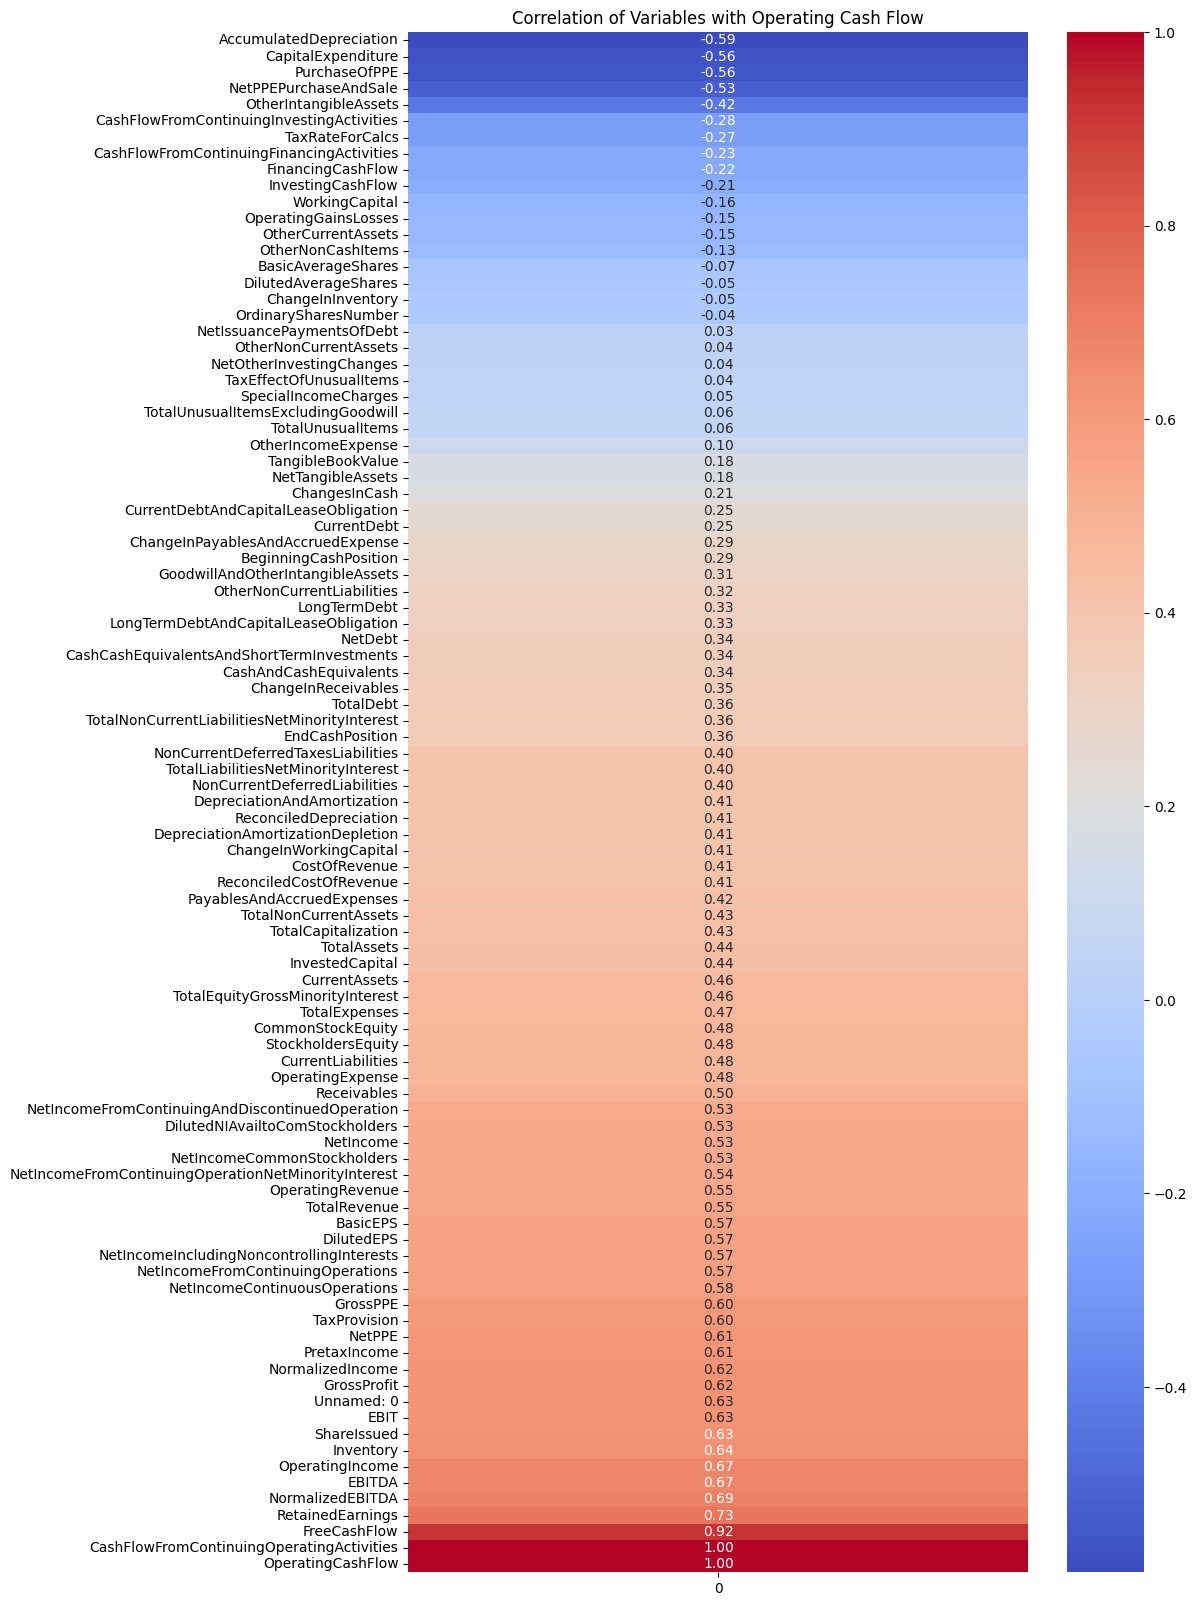

In [5]:
correlation = data.corr()[operating_cash_flow_col].sort_values()

# Fix the heatmap plot issue by converting to a numpy array
plt.figure(figsize=(10, 20))
sns.heatmap(correlation.values[:, None], annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            yticklabels=correlation.index)
plt.title('Correlation of Variables with Operating Cash Flow')
plt.show()

In [6]:
features = ["NetIncome", "GrossProfit", "EBITDA", "RetainedEarnings", "TotalRevenue", "OperatingIncome", "ChangeInWorkingCapital"]
target = 'OperatingCashFlow'
selected_data = data[features + [target]]
selected_data = selected_data.dropna()

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_data)
scaled_data = pd.DataFrame(scaled_data, columns=selected_data.columns)

In [8]:
def create_sequences(input_data, target_column, sequence_length):
    sequences = []
    target = []
    for i in range(len(input_data) - sequence_length):
        sequences.append(input_data[i:(i + sequence_length)].values)
        target.append(input_data.iloc[i + sequence_length][target_column])
    return np.array(sequences), np.array(target)

In [9]:
sequence_length = 8
X, y = create_sequences(scaled_data, target, sequence_length)

In [10]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(20, return_sequences=False),
    Dense(1)
])

In [19]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     hyperband_iterations=2)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
LSTM layer is {best_hps.get('units')} and the optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 180 Complete [00h 00m 10s]
val_loss: 0.053879424929618835

Best val_loss So Far: 0.04950007051229477
Total elapsed time: 00h 22m 58s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
LSTM layer is 224 and the optimal dropout rate is 0.0.
The optimal learning rate for the optimizer is 0.01.



KeyError: 'epochs does not exist.'

In [20]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 3s 227ms/step - loss: 2.8122 - val_loss: 0.1956
Epoch 2/50
4/4 [==============================] - 0s 28ms/step - loss: 0.2497 - val_loss: 0.6807
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1273 - val_loss: 0.2188
Epoch 4/50
4/4 [==============================] - 0s 25ms/step - loss: 0.0391 - val_loss: 0.0670
Epoch 5/50
4/4 [==============================] - 0s 29ms/step - loss: 0.0254 - val_loss: 0.0604
Epoch 6/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0130 - val_loss: 0.0528
Epoch 7/50
4/4 [==============================] - 0s 28ms/step - loss: 0.0118 - val_loss: 0.0565
Epoch 8/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0126 - val_loss: 0.0626
Epoch 9/50
4/4 [==============================] - 0s 28ms/step - loss: 0.0124 - val_loss: 0.0583
Epoch 10/50
4/4 [==============================] - 0s 29ms/step - loss: 0.0120 - val_loss: 0.0600
Epoch 11/50
4/4 [===========

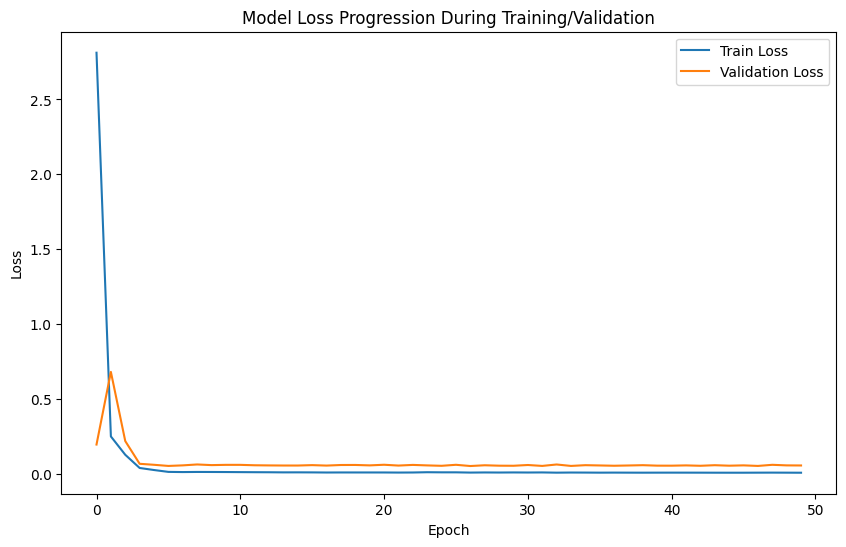

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [22]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.055846650153398514


In [25]:
# Make predictions on the test data
test_predictions = model.predict(X_test)

# Calculate the performance using a metric, for example, Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error on Test Data: {mae}')

1/1 [==============================] - 0s 76ms/step
Mean Absolute Error on Test Data: 0.17495388564304667
    Actual Values (Scaled)  Predicted Values (Scaled)
0                 0.842615                   0.737765
1                 0.458111                   0.735215
2                 0.745924                   0.757858
3                 0.886683                   0.740068
4                 0.791768                   0.758861
5                 0.585956                   0.753336
6                 0.955448                   0.756549
7                 0.818725                   0.760053
8                 0.846812                   0.785486
9                 0.563680                   0.773675
10                0.851170                   0.796134
11                0.000000                   0.770654
12                0.550928                   0.821657
13                0.484907                   0.735194
14                0.738176                   0.783968
15                0.412107    

In [ ]:
comparisons_scaled = pd.DataFrame({
    'Actual Values (Scaled)': y_test.flatten(),
    'Predicted Values (Scaled)': test_predictions.flatten()
})

print(comparisons_scaled)